##### How to Create Conda Environment
- Open terminal in the required directory.
- Type "conda create -n 'project_name' python=3.9.16"
- Select environment from Top Right corner, the environment that was created above.
- Next, Follow the instructions below.

##### Install Dependencies

- Python environment 3.8 or greater.
- Remember to download Anaconda and create a python environment
- Do remember to set-up a python environment containg the below dependencies in the directory.
- Run this cell only once.

In [7]:
## Download SAM dependencies
# ! pip install git+https://github.com/facebookresearch/segment-anything.git  # <-- Remove Hashtage to install
## Install Ultralytics for YOLOv8
# ! pip install ultralytics  # <-- Remove Hashtag to install 
## Download SAM Model Checkpoints for Inferencing
# ! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth  # <-- Remove Hashtage to install

##### Importing Libraries

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

##### Helper Functions

In [2]:
def show_anns(anns,color_map:dict):
    if len(anns) == 0:
        return

    img = np.ones((anns[0]['segmentation'].shape[0], anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for i,ann in enumerate(anns):
        m = ann['segmentation']
        color_mask = color_map[str(i)]
        img[m] = color_mask

    return img

def click_handler(cord,masks):
    hist = []
    counter = 0
    for i, mask in enumerate(masks):
        if mask['segmentation'][cord[0][1]][cord[0][0]]:
            # print(i)
            src_clr = color_map[str(i)]
            # break
        
    for i,mask in enumerate(masks):
        if mask['segmentation'][cord[1][1]][cord[1][0]]:
            counter+=1
            hist.append(i)
            # print(i)
    if len(hist)<2:
        try:
            print(hist)
            color_map[str(hist[0])] = src_clr
        except Exception as e:
            print(e, '(Please Click on Segmented Region.)') 
    else:
        indx = find_smallest(hist,masks,cord[1])
        color_map[str(indx)] = src_clr
        
    return color_map

def find_smallest(hist,masks,cord):
    for indx in reversed(hist):
        if masks[indx]['segmentation'][cord[1]][cord[0]]:
            return indx

def click_event(event, x, y, flags, param):
    global coords
    global final
    if event == cv2.EVENT_LBUTTONDOWN:  # double left click event
        coords.append((x, y))
        if len(coords) == 2:
            print(coords)
            color_map = click_handler(coords, masks)
            masked_img = show_anns(masks,color_map)
            image_test = image_original / 255
            overlay = image_test * 0.4 + masked_img[:, :, 0:3]*0.6
            final = overlay
            # cv2.line(overlay, coords[0], coords[1], (0, 255, 0), 2)
            cv2.imshow('image', overlay)
            coords = []

label_map = {
'0':[0, 0, 1, 0.35],
'1':[0, 1, 0, 0.35],
'2':[1, 0, 0, 0.35]
}
def show_mask(mask, ax=None, classes=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        
    elif classes is not None and random_color is False:
        color = label_map[str(classes)]
        color = np.array(color)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
        
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    # img = np.ones((mask[0].shape[0], mask[0].shape[1], 4))
    # img[:,:,3] = 0
    # for i,ann in enumerate(anns):
    #     m = ann['segmentation']
    #     color_mask = label_map[str(i)]
    #     img[m] = color_mask

    # return mask_image
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

##### Input Image Here and Run SAM and Detector Inference

- Input Image: 
- We have provided a few sample images inside the test folder. That can be used for testing.
- Other images besides ours can also be used, just need to provide a path of the image below.

Image Loaded
Inferenece Done...



0: 384x640 1 window, 80.2ms
Speed: 10.5ms preprocess, 80.2ms inference, 22.6ms postprocess per image at shape (1, 3, 640, 640)


window 0 [372.5064697265625, 346.04864501953125, 593.427978515625, 441.43280029296875]


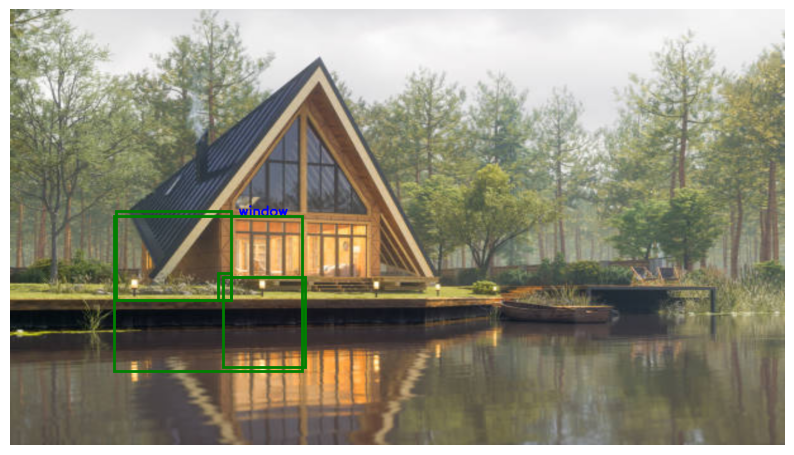

In [5]:
input_test_image = 'seg_data/only_seg/images/33.jpg' # <-- Input Image Path Here
image_original = cv2.imread(input_test_image) 
# image_original = cv2.resize(image_original, (1280, 720))
image_original = cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB)
print("Image Loaded")
# Input the path of the SAM model checkpoint for inferencing, if relative path to directory not working....
# ....provide full path
sam_checkpoint = "weights/sam_vit_h_4b8939.pth"  
model_type = "vit_h" 
device = "cpu"  # Choose what to use for infrerence ('cpu', 'cuda'), CPU recommended if GPU not available
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image_original)
print('Inferenece Done...')


image_detect = cv2.imread(input_test_image) 
# image_detect = cv2.resize(image_detect, (1280, 720))
image_detect = cv2.cvtColor(image_detect, cv2.COLOR_BGR2RGB)
model = YOLO('weights/detetor/best_house.pt')
# If you want to save detector output, change 'save=True' In below code.
objects = model(image_detect, save=False, line_thickness=1, 
                stream=False, show_conf=False, show_labels=False, conf=0.40) 

for o in objects:
    if o is None:
        print('No Detections Found...')
        break
    boxes = o.boxes # Boxes object for bbox output
    cls = boxes.cls.type(torch.int)
    for i, (c, bbox) in enumerate(zip(cls, boxes.xyxy.tolist())):
        class_names = ['window', 'door', 'garage']
        output_index = c
        class_name = class_names[output_index]

        if len(cls) > 0 and  cls[i] == c:
            print(class_name, c.item(), bbox)

            x1, y1, x2, y2 = bbox
            # cv2.rectangle(image_detect, (int(x1), int(y1)), (int(x2), int(y2)), (0,255,0), 2)
            text = class_name
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.75
            thickness = 2
            text_size, _ = cv2.getTextSize(text, font, font_scale, thickness)
            text_x = int(x1+5)
            text_y = int(y1-5)
            cv2.putText(image_detect, text, (text_x, text_y), font, font_scale, (0,0,255), thickness)

    #Implementing SAM 
    from segment_anything import sam_model_registry, SamPredictor

    sam_checkpoint = "weights/sam_vit_h_4b8939.pth"
    model_type = "vit_h"
    device = "cpu"  # Choose what to use for infrerence ('cpu', 'cuda'), CPU recommended if GPU not available

    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)

    predictor = SamPredictor(sam)
    predictor.set_image(image_detect)
    input_boxes = torch.tensor(boxes.xyxy, device=predictor.device)
    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image_detect.shape[:2])
    masks_det, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )
    # Plotting Segmented Classes
    cls =list(boxes.cls.cpu().numpy().astype(np.int32))
    plt.figure(figsize=(10, 10))
    plt.imshow(image_detect)
    for i ,mask in enumerate(masks_det):
        show_mask(mask=mask.cpu().numpy(), ax=plt.gca(), classes=cls[i], random_color=False)
# If you want to view the bounding boxes around the segmented area, remove Hastag at the start of below code.
    for box in input_boxes:        
        show_box(box.cpu().numpy(), plt.gca())  
    plt.axis('off')
    plt.savefig('sam_output/3.png')  # <-- If you want to save the below output, remove the Hashtag at the start. 
    plt.show()

- User Interface
- Run the cell below and wait for the UI to start. 

In [1]:
input_boxes

NameError: name 'input_boxes' is not defined

In [15]:
objects[0].boxes.xyxy

ultralytics.yolo.engine.results.Results object with attributes:

boxes: ultralytics.yolo.engine.results.Boxes object
keypoints: None
keys: ['boxes']
masks: None
names: {0: 'window', 1: 'door', 2: 'garage'}
orig_img: array([[[ 32,  60,  20],
        [ 65,  90,  58],
        [ 19,  37,  15],
        ...,
        [199, 217, 231],
        [200, 218, 232],
        [200, 218, 232]],

       [[  0,  27,   0],
        [  8,  32,   0],
        [ 10,  30,   5],
        ...,
        [199, 217, 231],
        [199, 217, 231],
        [200, 218, 232]],

       [[ 24,  50,  11],
        [ 24,  48,  14],
        [ 51,  71,  46],
        ...,
        [199, 217, 231],
        [199, 217, 231],
        [199, 217, 231]],

       ...,

       [[120, 135, 140],
        [128, 142, 151],
        [124, 136, 148],
        ...,
        [133, 135, 132],
        [134, 136, 133],
        [140, 142, 139]],

       [[124, 137, 145],
        [129, 142, 151],
        [124, 138, 149],
        ...,
        [147, 154, 160]

In [16]:
input_boxes

tensor([[ 86.9711, 283.3158, 278.7764, 365.3072],
        [244.3327, 124.8442, 344.2777, 185.4497],
        [418.1189, 251.7403, 473.2987, 315.5972],
        [321.9704, 259.3622, 356.0344, 330.0459]])

In [4]:
cls =list(boxes.cls.cpu().numpy().astype(np.int32))
size = masks_det[0][0].numpy().shape
mask=np.zeros(size, dtype=np.int32)
all_masks = np.squeeze(masks_det.numpy().astype(int),axis = 1)
for i ,each_mask in enumerate(all_masks):
        mask += each_mask * (cls[i]+1)
cv2.imwrite("test.png",mask)

True

In [5]:
new_cls = []
for i in cls:
    if i==0:
        new_cls.append(2)
    elif i==1:
        new_cls.append(0)
    elif i==2:
        new_cls.append(1)
print(cls)
print(new_cls)
size = masks_det[0][0].numpy().shape
mask=np.zeros(size, dtype=np.int32)
all_masks = np.squeeze(masks_det.numpy().astype(int),axis = 1)
for i ,each_mask in enumerate(all_masks):
        mask += each_mask * (new_cls[i]+1)
cv2.imwrite("test25.png",mask)

[0]
[2]


True

In [14]:
num_ones = np.count_nonzero(mask == 1)
num_zeros = np.count_nonzero(mask == 0)
num_twos = np.count_nonzero(mask == 2)
num_zeros, num_ones, num_twos

(890571, 3568, 27461)

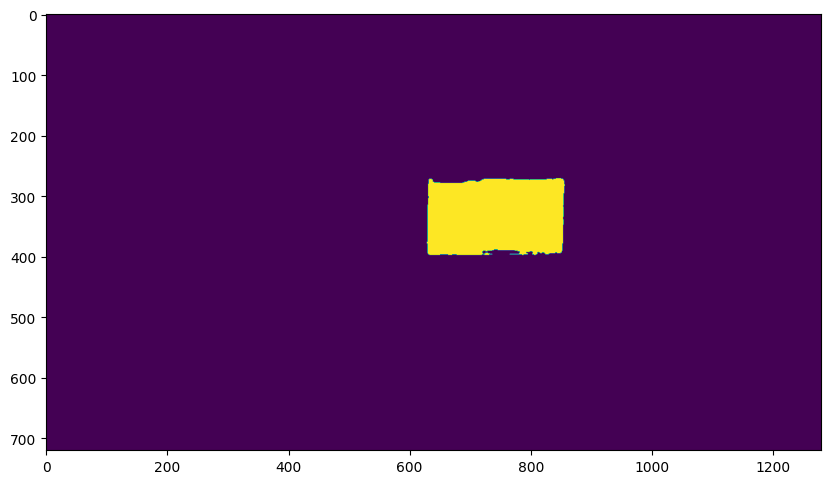

In [7]:
plt.figure(figsize=(10, 10))
plt.imshow(mask)
plt.show()

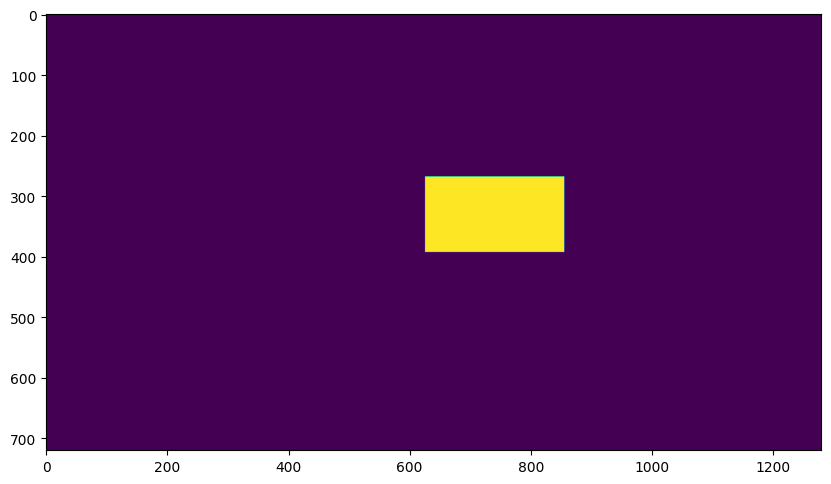

In [6]:
mask_gt = cv2.imread('seg_data/gnd_truths/25_gt.png',cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(10, 10))
plt.imshow(mask_gt)
plt.show()

In [17]:
import os
import shutil
import glob


def calculate_iou(gt_mask, pred_mask):
    intersection = np.logical_and(gt_mask, pred_mask)
    union = np.logical_or(gt_mask, pred_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def calculate_miou(gt_masks, pred_masks, num_classes):
    miou_sum = 0.0
    num_images = len(gt_masks)
    for i in range(num_images):
        gt_image_masks = gt_masks[i]
        pred_image_masks = pred_masks[i]
        iou_sum = 0.0
        for class_id in range(num_classes):
            gt_class_mask = (gt_image_masks == class_id).astype(np.uint8)
            pred_class_mask = (pred_image_masks == class_id).astype(np.uint8)
            iou = calculate_iou(gt_class_mask, pred_class_mask)
            iou_sum += iou
        miou_sum += iou_sum / num_classes
    miou = miou_sum / num_images
    return miou



gt_masks = []
pred_masks = []
files = os.listdir('seg_data/images/')
for file in files:
    fl_pred = file.replace('.jpg','_pred.png')
    fl_gnd = file.replace(".jpg","_gt.png")
    label_file = f"seg_data/gnd_truths/{fl_gnd}"
    pred_file = f"seg_data/pred/{fl_pred}"
    label_mask = cv2.imread(label_file,cv2.IMREAD_GRAYSCALE)
    pred_mask = cv2.imread(pred_file,cv2.IMREAD_GRAYSCALE)
    gt_masks.append(label_mask)
    pred_masks.append(pred_mask)
    # break


num_classes = 3

miou = calculate_miou(gt_masks, pred_masks, num_classes)
print("mIoU:", miou)

mIoU: nan


/tmp/ipykernel_12494/1472727017.py:9: RuntimeWarning: invalid value encountered in scalar divide
  iou = np.sum(intersection) / np.sum(union)


In [15]:
type(gt_masks[0])

numpy.ndarray

In [ ]:
# Example usage
gt_masks = np.array([   # Ground truth masks (shape: [num_samples, height, width])
    [[1, 0, 0], [0, 1, 1], [1, 1, 0]],
    [[1, 0, 1], [0, 1, 0], [0, 0, 1]]
])

pred_masks = np.array([   # Predicted masks (shape: [num_samples, height, width])
    [[1, 0, 0], [0, 1, 0], [1, 1, 0]],
    [[0, 0, 1], [1, 1, 0], [0, 0, 1]]
])

In [6]:
color_map=dict()
for i, mask in enumerate(masks):
    color_map[str(i)] = np.concatenate([np.random.random(3), [0.35]])

masked_img = show_anns(masks,color_map)
image_test = image_original / 255
overlay = image_test * 0.4 + masked_img[:, :, 0:3] * 0.6

print('UI Starting...')
# Creating a window to display the image
cv2.namedWindow('image')

# Set the mouse callback function for the targeted window
cv2.setMouseCallback('image', click_event)

# Initializing the list to store the coordinates of the mouse clicks
coords = []
final = []

# Display the image and wait for a key press
cv2.imshow('image', overlay)
cv2.waitKey(0)

## Save modified image
# Image automatically saved at the end in the directory after changes are made. If you want....
# .... to change the name of the saved file "cv2.imwrite('Enter New Name', final * 255)" below.
cv2.imwrite('final_seg.png', final * 255) 

## Clean up
cv2.destroyAllWindows()

UI Starting...
[(562, 403), (312, 388)]
[(503, 228), (775, 224)]
[(488, 224), (642, 226)]
[(481, 242), (459, 245)]


- View Final Saved Image Below

In [4]:
arr1 = [0,0,1,1,0,1]
arr2 = [0,1,1,1,0,0]
arr3 = np.logical_and(arr1,arr2)

In [5]:
arr3

array([False, False,  True,  True, False, False])

In [6]:
np.sum(arr3)

2

In [10]:
im1_gt = cv2.imread('seg_data/gnd_truths/25_gt.png',cv2.IMREAD_GRAYSCALE)
im1_pred = cv2.imread('test25.png',cv2.IMREAD_GRAYSCALE)
im1_gt = (im1_gt==2).astype(np.uint8)
im1_pred = (im1_pred==1).astype(np.uint8)
inter = np.logical_and(im1_gt,im1_pred)
union = np.logical_or(im1_gt,im1_pred)
np.sum(inter),np.sum(union)



(0, 0)

In [ ]:
num_ones = np.count_nonzero(mask == 1)
num_zeros = np.count_nonzero(mask == 0)
num_twos = np.count_nonzero(mask == 2)
num_zeros, num_ones, num_twos

In [24]:
im1_gt = cv2.imread('seg_data/gnd_truths/12_gt.png',cv2.IMREAD_GRAYSCALE)
im1_pred = cv2.imread('seg_data/pred/12_pred.png',cv2.IMREAD_GRAYSCALE)

im1_pred[im1_pred == 1] = 4
# Replace twos with ones
im1_pred[im1_pred == 2] = 1
# Replace threes (originally ones) with twos
im1_pred[im1_pred == 3] = 2
# Replace temporary value 4 with threes
im1_pred[im1_pred == 4] = 3

im1_gt = (im1_gt==1).astype(np.uint8)
im1_pred = (im1_pred==1).astype(np.uint8)
inter = np.logical_and(im1_gt,im1_pred)
union = np.logical_or(im1_gt,im1_pred)
np.sum(inter),np.sum(union)


(0, 26240)

In [3]:
import cv2
import numpy as np

img1_pred = cv2.imread('seg_data/only_seg/11_1_pred.png', cv2.IMREAD_GRAYSCALE)
list(np.unique(img1_pred))

[0, 1]

In [6]:
img1_pred

In [4]:
cv2.imshow('image', img1_pred)
cv2.waitKey(0)
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x56006607b380) is not the object's thread (0x560066d10f80).
Cannot move to target thread (0x56006607b380)

QObject::moveToThread: Current thread (0x56006607b380) is not the object's thread (0x560066d10f80).
Cannot move to target thread (0x56006607b380)

QObject::moveToThread: Current thread (0x56006607b380) is not the object's thread (0x560066d10f80).
Cannot move to target thread (0x56006607b380)

QObject::moveToThread: Current thread (0x56006607b380) is not the object's thread (0x560066d10f80).
Cannot move to target thread (0x56006607b380)

QObject::moveToThread: Current thread (0x56006607b380) is not the object's thread (0x560066d10f80).
Cannot move to target thread (0x56006607b380)

QObject::moveToThread: Current thread (0x56006607b380) is not the object's thread (0x560066d10f80).
Cannot move to target thread (0x56006607b380)

QObject::moveToThread: Current thread (0x56006607b380) is not the object's thread (0x560066d10f80).
Cannot move to tar

In [5]:
# Define the colors for each class
colors = {
    0: (0, 0, 0),        # Background (black)
    1: (255, 0, 0),      # Class 1 (red)
    2: (0, 255, 0),      # Class 2 (green)
    3: (0, 0, 255)       # Class 3 (blue)
}

# Load the binary mask image (single-channel image with class labels as pixel values)
# mask = cv2.imread('binary_mask.png', cv2.IMREAD_GRAYSCALE)

# Initialize an empty colored mask (3-channel image)
colored_mask = np.zeros((img1_pred.shape[0], img1_pred.shape[1], 3), dtype=np.uint8)

# Iterate over each class and assign the corresponding color to the colored mask
for class_label, color in colors.items():
    colored_mask[img1_pred == class_label] = color

cv2.imwrite('seg_data/only_seg/colored_test.png',colored_mask)

True